## 1. import libraries

Step of this section are:
1. Import the necessary libraries
2. Check if CUDA is available and set the device accordingly

In [38]:
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import torch as th
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchsummary import summary

# Ensure CUDA is available
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2.Load dataset
### 2.1 Load the MNIST with transformations and load the data to the device
Step of this section are:
1. Define transformations(training- add data augmentation and test- no data augmentation)
2. Load the MNIST dataset
3. image tensor shape is (B * H * W) and we need to convert it to (B * C * H * W) where C is the number of channels. In this case, C=1
4. load the data to the device


In [39]:
# define transformations
training_data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(28, padding=4),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.5),
])
test_data_transform = transforms.Compose([
    transforms.ToTensor(),
])

training_data = datasets.MNIST(root='./data', train=True, download=False, transform = training_data_transform)
test_data = datasets.MNIST(root="./data", train=False, download=False, transform = test_data_transform)
x_train, y_train = training_data.data, training_data.targets
x_test, y_test = test_data.data, test_data.targets

print(x_train.shape, y_train.shape)

# Add a dimension to tensor to become B*C*H*W
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1)
    x_test = x_test.unsqueeze(1)
    
print(x_train.shape, y_train.shape)

# Ensure CUDA is available
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

# x_train, y_train = x_train.to(device), y_train.to(device)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([60000, 1, 28, 28]) torch.Size([60000])
Using device: cuda


### 2.2 Displaying sample images
In the next cell, we will display the first 40 images in the training dataset.
to make the grid of images, we will use the `make_grid` function from `torchvision.utils`.
input to this function should be a 4D tensor of shape (B * C * H * W)

To the matplotlib `imshow` function, we need to convert the tensor to numpy array and then transpose it to (H * W * C) shape. or we can use the `permute` function to change the order of dimensions.

#### Note: utils.make_grid() will output a tensor of shape (3 * H * W) where 3 is the number of channels. So, we need to permute the dimensions to (H * W * C) before displaying the image.

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6])
torch.Size([3, 152, 242])


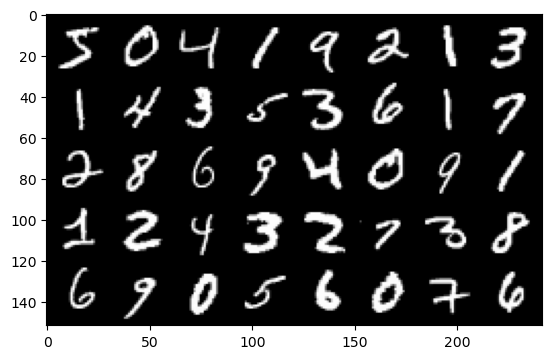

In [40]:
def show_tensor_image(image_tensor, label=None):
    print(image_tensor.shape)
    
    # image_tensor shape is H*W*C
    img = image_tensor.permute(1, 2, 0)
    
    # Ensure the tensor is on CPU
    img = img.cpu()
    
    plt.imshow(img, )
    
    if label is not None:
        plt.title(label)

#  utils.make_grid() will make a grid of 40 images input should be 4D tensor of shape (B*C*H*W)
x_grid = utils.make_grid(x_train[:40], nrow=8, padding=2)
print(y_train[0:40])
# print(x_grid.shape)

show_tensor_image(x_grid)

## 3. Create a Dataset
#### Advantages of Using TensorDataset
Simplicity: It simplifies the code needed to load and handle data, as you directly wrap existing tensors. There's no need for complex preprocessing or data loading pipelines if your data is already in tensor form.

Compatibility with DataLoader: TensorDataset is compatible with PyTorch's DataLoader, which can provide powerful options like batching, shuffling, and parallel data loading. For instance, you can pass the TensorDataset to a DataLoader to handle automatic batching:

In [41]:
# Create a TensorDataset
training_dataset = TensorDataset(x_train, y_train)  
test_dataset = TensorDataset(x_test, y_test)

for x, y in training_dataset:
    print(x.shape, y)
    break

torch.Size([1, 28, 28]) tensor(5)


## 4. Create a DataLoader
key inputs to DataLoader are:
1. **dataset**: The dataset to load the data from.
2. **batch_size**: The number of samples to load in each batch.
3. **shuffle**: Whether to shuffle the data at the beginning of each epoch (default is False).
4. **num_workers**: The number of processes to use for data loading. By default, it is set to 0, which means that the data will be loaded in the main process. Increasing the number of workers can help speed up data loading, especially when the data is stored on disk. However, using multiple workers also increases the memory usage, so you may need to increase the memory available to the DataLoader if you increase the number of workers.
5. **pin_memory**: Whether to use pinned memory for the DataLoader. Pinned memory is a special kind of memory that is locked in place and can be moved to the GPU more efficiently. By default, it is set to False, but you can set it to True if you are loading data to a CUDA-enabled device.
6. **drop_last**: Whether to drop the last incomplete batch if the dataset size is not divisible by the batch size. By default, it is set to False, which means that the last batch will be smaller if the dataset size is not divisible by the batch size.
7. **timeout**: The maximum amount of time to wait for the worker processes to return the data. By default, it is set to 0, which means that the main process will wait indefinitely for the worker processes to return the data. You can set it to a positive number to avoid waiting indefinitely.    
8.** worker_init_fn**: A function that will be called in each worker process to perform worker-specific initialization. This can be useful if you need to set the random seed for each worker process or perform other worker-specific initialization tasks.    
9. **sampler**: An object that defines the strategy for sampling the data from the dataset. By default, it is set to None, which means that the data will be sampled randomly. You can use a sampler object to implement more complex sampling strategies, such as stratified sampling or sequential sampling.
10. **collate_fn**: A function that will be called to collate the data samples into a batch. By default, it is set to None, which means that the data samples will be collated using the default collate function. You can define a custom collate function if you need to perform additional processing on the data samples before they are loaded into the DataLoader.
11. **batch_sampler**: An object that defines the strategy for sampling the data from the dataset in batches. By default, it is set to None, which means that the data will be sampled randomly in batches. You can use a batch_sampler object to implement more complex sampling strategies, such as stratified sampling or sequential sampling in batches.
12. **generator**: A random number generator that will be used to generate random numbers for shuffling the data. By default, it is set to None, which means that a new random number generator will be created for each DataLoader. You can set it to a specific random number generator if you need to control the random number generation.
13. **prefetch_factor**: The number of batches to prefetch in the DataLoader. By default, it is set to 2, which means that the DataLoader will prefetch 2 batches of data in advance. Increasing the prefetch factor can help speed up data loading, especially when the data is stored on disk. However, increasing the prefetch factor also increases the memory usage, so you may need to increase the memory available to the DataLoader if you increase the prefetch factor. 
14. **persistent_workers**: Whether to keep the worker processes alive between epochs. By default, it is set to False, which means that the worker processes will be terminated at the end of each epoch. You can set it to True if you want to keep the worker processes alive between epochs to avoid the overhead of starting and stopping the worker processes.



 Determining the optimal number of workers (`num_workers`) in PyTorch's `DataLoader`:

1. **Hardware Cores**:
   - Align the number of workers with the number of CPU cores to maximize efficiency. More cores typically support more workers without significant context switching overhead.

2. **Memory Constraints**:
   - Ensure there is enough RAM to support the simultaneous operation of multiple workers. Each worker consumes memory, and insufficient memory can lead to swapping or crashes.

3. **Disk Speed**:
   - Consider the speed of your storage system. SSDs can support more simultaneous reads (and thus more workers) compared to HDDs.

4. **Data Preprocessing Complexity**:
   - If data transformations are complex and CPU-intensive, more workers can help parallelize these tasks and reduce the time to get batches ready.

5. **Batch Size**:
   - Larger batch sizes mean more data to process per batch. More workers can help manage larger batches more efficiently by parallelizing data preparation.

6. **Experimentation**:
   - Start with a number of workers equivalent to the number of CPU cores and adjust based on observed performance and system resource utilization.

7. **System Monitoring**:
   - Use tools to monitor CPU, memory, and I/O utilization to identify bottlenecks and adjust the number of workers accordingly.

8. **Balanced Approach**:
   - Aim for a balance where all workers are consistently busy but not overloaded, ensuring smooth data flow without straining system resources.

9. **Context Switching**:
   - Avoid too many workers as this can lead to excessive context switching, reducing overall efficiency.

10. **Diminishing Returns**:
    - Watch for diminishing returns as you increase the number of workers; finding a point where increasing workers doesn’t significantly improve or even worsens performance can indicate you've reached an optimal level.

Each of these points helps tailor the number of worker processes to your specific training setup, enhancing overall data loading and processing efficiency during model training.

#### Note:  If your tensors are already on the GPU (as a torch.cuda.ByteTensor indicates), pin_memory should not be used

In [42]:
training_data_loader = DataLoader(training_dataset, batch_size=100, shuffle=True, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# iterate over batches
for xb,yb in training_data_loader:
    print(xb.shape)
    print(yb)
    break

torch.Size([100, 1, 28, 28])
tensor([4, 4, 8, 8, 5, 2, 8, 3, 7, 2, 7, 0, 4, 0, 5, 6, 1, 2, 3, 9, 5, 1, 7, 6,
        6, 7, 3, 0, 6, 2, 1, 0, 3, 6, 9, 6, 6, 7, 6, 2, 1, 6, 4, 1, 5, 1, 0, 8,
        7, 4, 7, 1, 7, 7, 6, 3, 8, 2, 6, 7, 5, 1, 0, 9, 4, 3, 2, 8, 7, 9, 2, 2,
        3, 6, 1, 3, 8, 9, 6, 0, 4, 7, 3, 5, 1, 2, 8, 4, 3, 3, 9, 6, 9, 4, 4, 6,
        7, 1, 1, 3])


s## 5. Create a Neural Network
### 5.1 Define a Neural Network in PyTorch and initialize it

Explain the key components of a neural network in PyTorch:

1. **nn.Module**:
   - The base class for all neural network modules in PyTorch.
   - To define a neural network in PyTorch, you create a new class that inherits from `nn.Module`.
   - The class must implement two methods: `__init__` and `forward`.
   - The `__init__` method initializes the layers of the neural network.
   - The `forward` method defines the forward pass of the neural network.
   - The `forward` method is called when you pass input data to the neural network.

2. **Layers**:      
   - Layers are the building blocks of a neural network.
   - PyTorch provides a wide range of layers, such as `Linear`, `Conv2d`, `MaxPool2d`, and `ReLU`.
   - You can create a layer by instantiating the corresponding class and passing the required parameters.
   - Layers are typically defined in the `__init__` method of the neural network class.
      - Example: `self.fc = nn.Linear(in_features, out_features)`
3. **Activation Functions**:
   - Activation functions introduce non-linearity into the neural network.
   - Common activation functions include `ReLU`, `Sigmoid`, and `Tanh`.
   - Activation functions are applied to the output of a layer to introduce non-linearities.
   - Activation functions are typically applied in the `forward` method of the neural network class.
      - Example: `x = F.relu(x)`
            - where `x` is the output of a layer.
4. **pooling layers**:
   - Pooling layers reduce the spatial dimensions of the input volume.
   - Common pooling layers include `MaxPool2d` and `AvgPool2d`.
   - Pooling layers are used to downsample the input volume and reduce the number of parameters.
   - Pooling layers are typically applied in the `forward` method of the neural network class.
      - Example: `x = F.max_pool2d(x, kernel_size)`
            - where `x` is the input volume and `kernel_size` is the size of the pooling window.
5. **log_softmax**: 
   - Equations: 
        - Softmax function: $P(y=j|x) = \frac{e^{x_j}}{\sum_{k} e^{x_k}}$
        - Log-softmax function: $log(P(y=j|x)) = log(\frac{e^{x_j}}{\sum_{k} e^{x_k}})$
   - The `log_softmax` function is used to compute the logarithm of the softmax function.
   - The softmax function is used to convert the output of the neural network into a probability distribution.
   - The `log_softmax` function is typically applied to the output of the final layer of the neural network.
   - The `log_softmax` function is applied in the `forward` method of the neural network class.
      - Example: `x = F.log_softmax(x, dim=1)`
            - where `x` is the output of the final layer.
   
   #### importance of log_softmax: 
        1. Numerical Stability: The log operation helps prevent numerical underflow when dealing with very small probabilities. 
        2. Loss Calculation: The log-likelihood loss is commonly used in classification tasks, and the log_softmax function is a key component of this loss calculation.
        3. Gradient Optimization: The log_softmax function is differentiable, making it suitable for gradient-based optimization algorithms like backpropagation.

In [43]:
class modelLL(nn.Module):
    def __init__(self):
        super(modelLL, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, 1)
        self.conv2 = nn.Conv2d(8, 16, 5, 1)
        self.fc1 = nn.Linear(4*4*16, 100)
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        #first convolution layer with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        #first convolution layer with ReLU and max pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 4*4*16)
        
        #first fully connected layer
        x = F.relu(self.fc1(x))
        
        #second fully connected layer
        x = self.fc2(x)
        
        # Apply log_softmax to the output. dim=1 indicates the dimension along which the softmax function is applied. returns a tensor of shape (B * C) B-batch size C- class size. 
        return F.log_softmax(x, dim=1)
           
modelLL = modelLL()
print(modelLL)
        

modelLL(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [44]:
class modelWithoutLL(nn.Module):
    def __init__(self):
        super(modelWithoutLL, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, 1)
        self.conv2 = nn.Conv2d(8, 16, 5, 1)
        self.fc1 = nn.Linear(4*4*16, 100)
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        #first convolution layer with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        #first convolution layer with ReLU and max pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 4*4*16)
        
        #first fully connected layer
        x = F.relu(self.fc1(x))
        
        #second fully connected layer
        x = self.fc2(x)
        
        # Apply log_softmax to the output. dim=1 indicates the dimension along which the softmax function is applied. returns a tensor of shape (B * C) B-batch size C- class size. 
        return x
           
modelWithoutLL = modelWithoutLL()
print(modelWithoutLL)
        

modelWithoutLL(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


### 5.2 Model Summary and Move the model to the device

In [45]:
modelWithoutLL.to(device)
modelLL.to(device)
print("Summary of model with log_softmax")
summary(modelLL, (1, 28, 28))
print("Summary of model without log_softmax")
summary(modelWithoutLL, (1, 28, 28))

Summary of model with log_softmax
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 24, 24]           208
├─Conv2d: 1-2                            [-1, 16, 8, 8]            3,216
├─Linear: 1-3                            [-1, 100]                 25,700
├─Linear: 1-4                            [-1, 10]                  1,010
Total params: 30,134
Trainable params: 30,134
Non-trainable params: 0
Total mult-adds (M): 0.35
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.11
Estimated Total Size (MB): 0.16
Summary of model without log_softmax
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 24, 24]           208
├─Conv2d: 1-2                            [-1, 16, 8, 8]            3,216
├─Linear: 1-3                            [-1, 100]                 25,700
├─Linear: 1-4                            [-1, 10]          

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 24, 24]           208
├─Conv2d: 1-2                            [-1, 16, 8, 8]            3,216
├─Linear: 1-3                            [-1, 100]                 25,700
├─Linear: 1-4                            [-1, 10]                  1,010
Total params: 30,134
Trainable params: 30,134
Non-trainable params: 0
Total mult-adds (M): 0.35
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.11
Estimated Total Size (MB): 0.16

## 6. Define Loss Function and Optimizer

In [46]:
loss_function1 = nn.CrossEntropyLoss()
loss_function2 = nn.NLLLoss()

optimizer1 = th.optim.Adam(modelWithoutLL.parameters(), lr=0.0001)
optimizer2 = th.optim.Adam(modelLL.parameters(), lr=0.0001)

## 7. Training the model

In [47]:
# Training the model with log_softmax
print("Training the model with log_softmax")
for epoch in range(5):
    for xb, yb in training_data_loader:
        xb=xb.type(th.float).to(device)
        yb=yb.to(device)
        # Clear the gradients
        optimizer2.zero_grad()
        
        # Forward pass
        output2 = modelLL(xb)
        
        # Calculate the loss
        loss2 = loss_function2(output2, yb)
        
        # Backward pass
        loss2.backward()
        
        # Update the weights
        optimizer2.step()
        
    print(f"Epoch {epoch+1}, Loss2: {loss2.item()}")
    
# Training the model without log_softmax
print("Training the model without log_softmax")
for epoch in range(5):
    for xb, yb in training_data_loader:
        xb=xb.type(th.float).to(device)
        yb=yb.to(device)
        # Clear the gradients
        optimizer1.zero_grad()
        
        # Forward pass
        output1 = modelWithoutLL(xb)
        
        # Calculate the loss
        loss1 = loss_function1(output1, yb)
        
        # Backward pass
        loss1.backward()
        
        # Update the weights
        optimizer1.step()
        
    print(f"Epoch {epoch+1}, Loss1: {loss1.item()}")

Training the model with log_softmax
Epoch 1, Loss2: 0.420739084482193
Epoch 2, Loss2: 0.22414787113666534
Epoch 3, Loss2: 0.0755549743771553
Epoch 4, Loss2: 0.09822526574134827
Epoch 5, Loss2: 0.058121129870414734
Training the model without log_softmax
Epoch 1, Loss1: 0.24824728071689606
Epoch 2, Loss1: 0.38235342502593994
Epoch 3, Loss1: 0.04711266979575157
Epoch 4, Loss1: 0.06194014847278595
Epoch 5, Loss1: 0.10555268079042435


## 8. Testing the model

In [32]:
#model with eval mode
modelWithoutLL.eval()
modelLL.eval()

correct1 = 0
total1 = 0
correct2 = 0
total2 = 0

#with th.no_grad():
with th.no_grad():
    for xb, yb in test_data_loader:
        xb=xb.type(th.float).to(device)
        yb=yb.to(device)
        output1 = modelWithoutLL(xb)
        output2 = modelLL(xb)
        _, predicted1 = th.max(output1.data, 1)
        _, predicted2 = th.max(output2.data, 1)
        total1 += yb.size(0)
        correct1 += (predicted1 == yb).sum().item()
        total2 += yb.size(0)
        correct2 += (predicted2 == yb).sum().item()
        
print(f"Accuracy of the model without log_softmax: {100 * correct1 / total1}")
print(f"Accuracy of the model with log_softmax: {100 * correct2 / total2}")
        

Accuracy of the model without log_softmax: 97.11
Accuracy of the model with log_softmax: 97.83


## 9. Save the model

## 9.1 Save the model as state_dict
In PyTorch, the learnable parameters (i.e., weights and biases) of an `torch.nn.Module` model are contained in the model’s parameters (accessed with `model.parameters()`). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. The state_dict object is serializable and can be saved to disk as a binary file using `torch.save`.

When saving a model for inference, it is only necessary to save the model’s state_dict. Saving the model’s state_dict with the torch.save() function will give you the most flexibility for restoring the model later, which is why it is the recommended method for saving models.

In [33]:
# Save the model
th.save(modelWithoutLL.state_dict(), "modelWithoutLL_state_dict.pth")
th.save(modelLL.state_dict(), "modelLL_state_dict.pth")


In [35]:
# Load the model
modelWithoutLL.load_state_dict(th.load("modelWithoutLL_state_dict.pth"))
modelLL.load_state_dict(th.load("modelLL_state_dict.pth"))

#model with eval mode
modelWithoutLL.eval()
modelLL.eval()

correct1 = 0
total1 = 0
correct2 = 0
total2 = 0

#with th.no_grad():
with th.no_grad():
    for xb, yb in test_data_loader:
        xb=xb.type(th.float).to(device)
        yb=yb.to(device)
        output1 = modelWithoutLL(xb)
        output2 = modelLL(xb)
        _, predicted1 = th.max(output1.data, 1)
        _, predicted2 = th.max(output2.data, 1)
        total1 += yb.size(0)
        correct1 += (predicted1 == yb).sum().item()
        total2 += yb.size(0)
        correct2 += (predicted2 == yb).sum().item()
        
print(f"Accuracy of the model without log_softmax: {100 * correct1 / total1}")
print(f"Accuracy of the model with log_softmax: {100 * correct2 / total2}")


Accuracy of the model without log_softmax: 97.11
Accuracy of the model with log_softmax: 97.83


## 9.2 Save the entire model
In PyTorch, the entire model can be saved to disk as a binary file using `torch.save`. This allows you to save the entire model, including its architecture, learnable parameters, and any other state information. When saving the entire model, you can later load the model using `torch.load` and resume training or perform inference.

When saving the entire model, you can save the model as a Python dictionary containing the model’s architecture and state_dict. This dictionary can be saved to disk using `torch.save`.

In [48]:
th.save(modelWithoutLL, "modelWithoutLL_whole.pth")
th.save(modelLL, "modelLL_whole.pth")


PicklingError: Can't pickle <class '__main__.modelWithoutLL'>: it's not the same object as __main__.modelWithoutLL

In [36]:
# Load the model
modelWithoutLL = th.load("modelWithoutLL_whole.pth")
modelLL = th.load("modelLL_whole.pth")

#model with eval mode
modelWithoutLL.eval()
modelLL.eval()

correct1 = 0
total1 = 0
correct2 = 0
total2 = 0

#with th.no_grad():
with th.no_grad():
    for xb, yb in test_data_loader:
        xb=xb.type(th.float).to(device)
        yb=yb.to(device)
        output1 = modelWithoutLL(xb)
        output2 = modelLL(xb)
        _, predicted1 = th.max(output1.data, 1)
        _, predicted2 = th.max(output2.data, 1)
        total1 += yb.size(0)
        correct1 += (predicted1 == yb).sum().item()
        total2 += yb.size(0)
        correct2 += (predicted2 == yb).sum().item()

FileNotFoundError: [Errno 2] No such file or directory: 'modelWithoutLL_whole.pth'

# Additional Resources: nn.Relu vs F.relu
In the context of neural networks, particularly when using PyTorch, `nn.ReLU` and `F.relu` refer to two different ways of applying the ReLU (Rectified Linear Unit) activation function, but they essentially perform the same operation. Here’s a breakdown of each and when you might choose one over the other:

### nn.ReLU
- `nn.ReLU` belongs to the `torch.nn` module and is used as a module, typically added as a component of a neural network model.
- It can be easily included in a sequential model or added to a model using class inheritance, where it acts as a layer within the network.
- This module approach is more suited for situations where you want to maintain a clean and modular architecture, as it can be beneficial for tracking and managing the model’s layers.

**Example usage in a model:**
```python
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(in_features=100, out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=10)
)
```

### F.relu
- `F.relu` is part of the `torch.nn.functional` module and is used directly as a function.
- This function is called with an input tensor, and it returns the output tensor after applying the ReLU function. It is stateless, meaning it doesn't learn any parameters.
- `F.relu` is more flexible for writing custom layers or functions since it can be added anywhere a tensor needs to be processed without adding a layer to the model.

**Example usage in custom functions or layers:**
```python
import torch
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=100, out_features=50)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)  # Applying ReLU functionally
        return x
```

### Choosing Between `nn.ReLU` and `F.relu`
- **Modularity and Readability**: Use `nn.ReLU` if you prefer a modular network architecture and want to use built-in PyTorch functionalities like `Sequential`.
- **Customization and Direct Control**: Use `F.relu` when you need more control over how exactly the activation is applied, or when you are defining more complex operations in your model's forward method.

Both methods are valid and widely used, and the choice between them often depends on the specific requirements of your project and your personal or organizational coding standards.

# Conclusion
In this notebook, we covered the following topics:

1. Loading the MNIST dataset using PyTorch's `torchvision.datasets` module.
2. Creating a custom `TensorDataset` and `DataLoader` for the MNIST dataset.
3. Defining a neural network model using PyTorch's `torch.nn.Module` class.
4. Training the model using a custom training loop and evaluating its performance.
5. Saving and loading the model's state_dict and the entire model using `torch.save` and `torch.load`.
6. Comparing the performance of the model with and without the `log_softmax` function.
7. Understanding the differences between `nn.ReLU` and `F.relu` in PyTorch.
8. Exploring the importance of the `log_softmax` function in classification tasks.
9. Discussing the optimal number of workers in PyTorch's `DataLoader` for efficient data loading.
10. Highlighting the key components of a neural network in PyTorch, such as layers, activation functions, and loss functions.